In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

In [9]:
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: NVIDIA A100-SXM4-40GB


In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  3 18:00:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [13]:
movie_review = pd.read_csv("/content/drive/MyDrive/Movie_Reviews_Dataset/IMDB Dataset.csv")

In [14]:
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
movie_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [16]:
movie_review.isnull().sum()

review       0
sentiment    0
dtype: int64

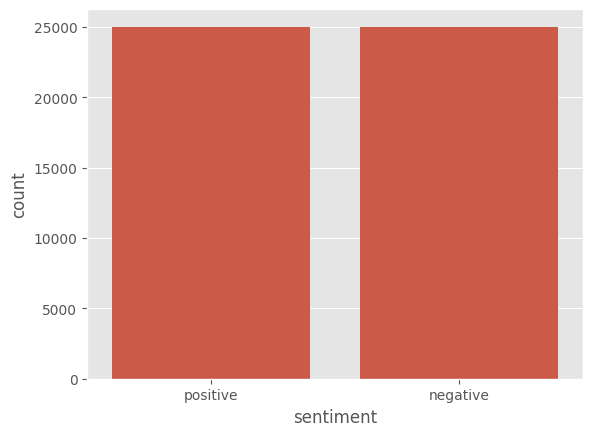

In [17]:
plt.style.use("ggplot")
sns.countplot(data = movie_review, x = movie_review["sentiment"])
plt.show()

In [18]:
movie_review["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

# Data Preprocess

In [19]:
def preprocess_data(sentence):
  stop_words = stopwords.words("english")
  stop_words.extend(["movie", "film"])

  html_tag = re.compile(r'<[^>]+>')
  sentence = sentence.lower()
  # html tagleri silme
  sentence = html_tag.sub('', sentence)
  # noktalama isaretleri ve sayilari silme
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  # tek kalan karakterleri silme
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # birden fazla boşluklari silme
  sentence = re.sub(r'\s+', ' ', sentence)
  # durdurma kelimelerini silme
  pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence

In [20]:
x = []
sentences = list(movie_review["review"])
for sen in sentences:
  x.append(preprocess_data(sen))

In [21]:
x[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [22]:
# negatif yorumları 0 pozitif yorumları 1 yapıyoruz
y = movie_review["sentiment"]
y = np.array(y.map({'negative' : 0, 'positive': 1}))
y[:5]

array([1, 1, 1, 0, 1])

In [23]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
exclude = set(string.punctuation)

#for positive sentiments
df_pos = movie_review[movie_review["sentiment"]=="positive"]

#for only unigrams
token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in x[i])
    tokens=word_tokenize(text)
    tokens=[tok for tok in tokens]
    token_list.extend(tokens)

frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

### Pozitif yorumlarda en çok geçen kelimeler

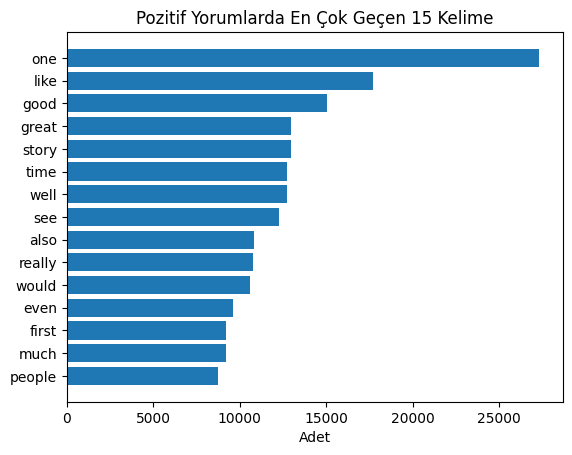

In [24]:
plt.rcdefaults()
fig, ax = plt.subplots()


ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Adet')
ax.set_title('Pozitif Yorumlarda En Çok Geçen 15 Kelime')

plt.show()

In [25]:
exclude = set(string.punctuation)

#for negative review
df_neg = movie_review[movie_review["sentiment"]=="negative"]

#for only unigrams
neg_token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in x[i])
    tokens=word_tokenize(text)
    tokens=[tok for tok in tokens]
    neg_token_list.extend(tokens)

frequencies_neg=Counter(neg_token_list)
frequencies_sorted_neg=sorted(frequencies_neg.items(), key=lambda k: k[1],reverse=True)
top_15_neg=dict(frequencies_sorted_neg[0:15])

### Negatif yorumlarda en çok geçen kelimeler

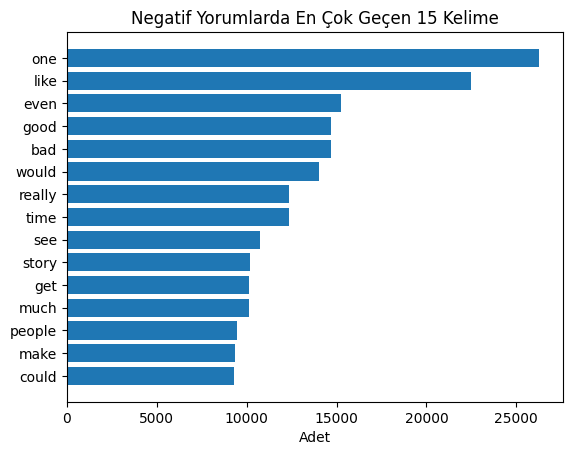

In [26]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram_neg = top_15_neg.keys()
y_neg = np.arange(len(ngram_neg))
performance_neg = top_15_neg.values()


ax.barh(y_neg, performance_neg, align='center')
ax.set_yticks(y_neg)
ax.set_yticklabels(ngram_neg)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Adet')
ax.set_title('Negatif Yorumlarda En Çok Geçen 15 Kelime')

plt.show()

### Pozitif yorumlarda yan yana en çok geçen kelimeler

In [27]:
from nltk.util import ngrams
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

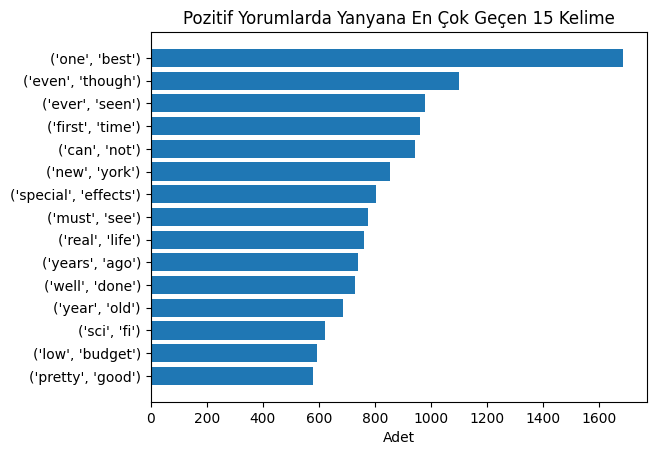

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots()

ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Adet')
ax.set_title('Pozitif Yorumlarda Yanyana En Çok Geçen 15 Kelime')

plt.show()

In [29]:
bigrams_neg=list(ngrams(neg_token_list,2))
frequencies_neg=Counter(bigrams_neg)
frequencies_sorted_neg=sorted(frequencies_neg.items(), key=lambda k: k[1],reverse=True)
top_15_neg=dict(frequencies_sorted_neg[0:15])

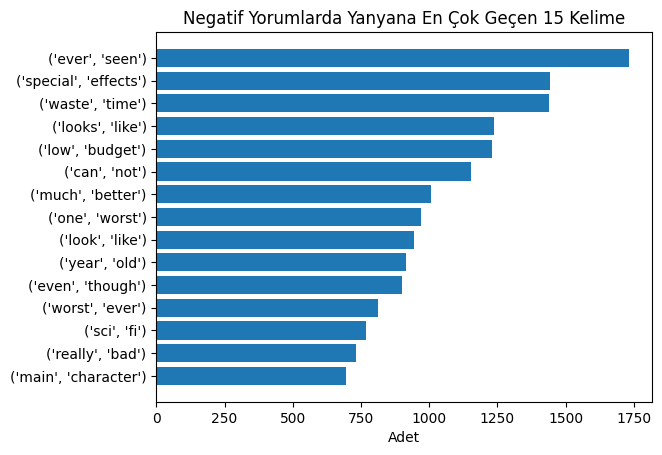

In [30]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram_neg = top_15_neg.keys()
y_pos = np.arange(len(ngram_neg))
performance_neg = top_15_neg.values()

ax.barh(y_pos, performance_neg, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram_neg)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Adet')
ax.set_title('Negatif Yorumlarda Yanyana En Çok Geçen 15 Kelime')

plt.show()

In [31]:
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet/xlnet-base-cased', do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

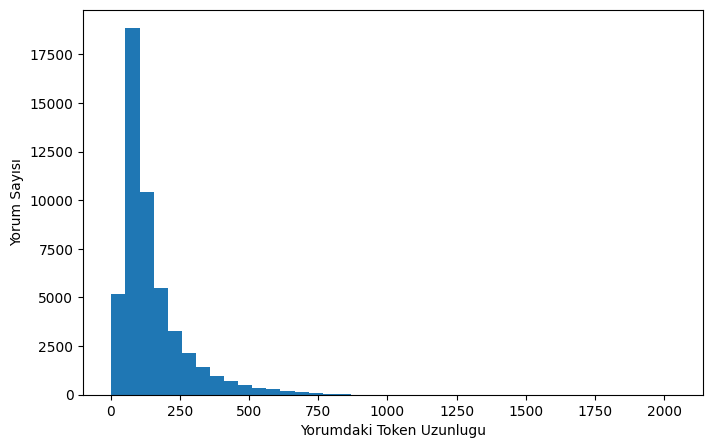

In [32]:
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(x, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), x))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Yorumdaki Token Uzunlugu");
    ax.set_ylabel("Yorum Sayısı");
    return
plot_sentence_embeddings_length(x, tokenizer)

In [33]:
len(x)

50000

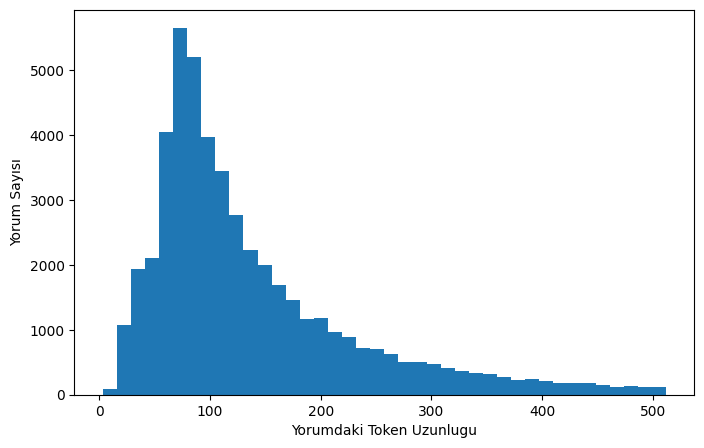

In [34]:
def filter_long_comments_and_labels(x, y, tokenizer, max_length=512):
    # Yorumları tokenize et
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), x))

    # Token sayısı 512'den az olan yorumları ve onların etiketlerini filtrele
    filtered_x_y = [(text, label) for text, label, tokens in zip(x, y, tokenized_texts) if len(tokens) <= max_length]

    # Filtrelenmiş x ve y listelerini ayır
    filtered_x = [text for text, label in filtered_x_y]
    filtered_y = [label for text, label in filtered_x_y]

    return filtered_x, filtered_y

filtered_x, filtered_y = filter_long_comments_and_labels(x, y, tokenizer)

# Yeni veri seti ile histogramı yeniden çiz
plot_sentence_embeddings_length(filtered_x, tokenizer)

In [35]:
len(filtered_x)

48920

In [36]:
len(filtered_y)

48920

In [37]:
indices = tokenizer.batch_encode_plus(filtered_x, max_length=512, add_special_tokens=True, padding='max_length', truncation=True)
input_ids = indices["input_ids"]
attention_masks = indices["attention_mask"]
print(input_ids[0])
print(filtered_x[0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 65, 16010, 23, 2911, 2441, 17, 6495, 2842, 15943, 203, 2034, 1525, 89

In [38]:
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, filtered_y,
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, filtered_y,
                                             random_state=42, test_size=0.2)

In [39]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Eğitim setimiz için DataLoader oluşturun.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validasyon setimiz için DataLoader oluşturun.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [41]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "xlnet/xlnet-base-cased",num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(
    "xlnet/xlnet-base-cased",config=config)
model.cuda()

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [42]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  betas=[0.9,0.999],
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Eğitim epoklarının sayısı (2 ile 4 arası önerilmektedir)
epochs = 2

# Toplam eğitim adımı sayısı, grup sayısı * epok sayısıdır.
total_steps = len(train_dataloader) * epochs

# Öğrenme oranı zamanlayıcısını oluşturun.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 30 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()

        outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels)


        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    30  of  1,223.    Elapsed: 0:00:39.
  Batch    60  of  1,223.    Elapsed: 0:01:16.
  Batch    90  of  1,223.    Elapsed: 0:01:53.
  Batch   120  of  1,223.    Elapsed: 0:02:30.
  Batch   150  of  1,223.    Elapsed: 0:03:07.
  Batch   180  of  1,223.    Elapsed: 0:03:44.
  Batch   210  of  1,223.    Elapsed: 0:04:21.
  Batch   240  of  1,223.    Elapsed: 0:04:58.
  Batch   270  of  1,223.    Elapsed: 0:05:35.
  Batch   300  of  1,223.    Elapsed: 0:06:12.
  Batch   330  of  1,223.    Elapsed: 0:06:49.
  Batch   360  of  1,223.    Elapsed: 0:07:26.
  Batch   390  of  1,223.    Elapsed: 0:08:04.
  Batch   420  of  1,223.    Elapsed: 0:08:41.
  Batch   450  of  1,223.    Elapsed: 0:09:18.
  Batch   480  of  1,223.    Elapsed: 0:09:55.
  Batch   510  of  1,223.    Elapsed: 0:10:32.
  Batch   540  of  1,223.    Elapsed: 0:11:09.
  Batch   570  of  1,223.    Elapsed: 0:11:46.
  Batch   600  of  1,223.    Elapsed: 0:12:23.
  Batch   630  of

In [46]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1, b_labels1 = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1,
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('    DONE.')

Predicting labels for 9,784 test sentences...
    DONE.


In [47]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [48]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.9205846279640229


In [49]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4954
           1       0.92      0.92      0.92      4830

    accuracy                           0.92      9784
   macro avg       0.92      0.92      0.92      9784
weighted avg       0.92      0.92      0.92      9784



In [50]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Movie_Reviews_Dataset/sentiment_analysis_from_xlnet_data_process.pth')
torch.save(model.state_dict(), '/content/drive/MyDrive/Movie_Reviews_Dataset/sentiment_analysis_from_xlnet_data_process.bin')